In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100 # this and above will make the figures large enough to read
def loadamesdata(trainfrac = 0.5):
    import pandas as pd
    from IPython.display import display
    
    dataframe = pd.read_table('AmesHousing.txt',delimiter='\t')

    dataframe = dataframe[dataframe['Gr Liv Area']<4000] # remove the five really large houses
    dataframe = dataframe[dataframe['Sale Condition']=='Normal'] # don't consider partial sales or other types of abnormal sales
    dataframe = dataframe.drop(columns=['Order','PID','Sale Condition'])
    
    categoricalf = [col for col in dataframe if dataframe[col].dtype.name=='object' or col=='MS SubClass']
     # Here we are encoding the categorical variables using a "one-hot" encoding.  A variable with 3 values (A, B, C)
    # gets converted into three binary variables.  For any example (row) exactly one of these binary variables is 1
    # indicating which value the original categorical variable took on.
    dataframe = pd.get_dummies(dataframe,columns=categoricalf,prefix=categoricalf,dummy_na=True)
    # Here we are going to remove any item that is missing a value (encoded as NaN at this stage)
    # This is slightly problematic (it could be the missingness is actually related to the value or other features' values)
    # Filling it in (with say the average for that feature) is also problematic, in different ways
    # So for this problem set, we'll just remove listings (rows) that are missing any of their non-categorical features
    dataframe.dropna(inplace=True) # 
    
    dataframe = dataframe.loc[:,(dataframe!=dataframe.iloc[0]).any()] # drop features that have all the same value (across both training and testing)
    
    dataframe['SalePrice'] = dataframe['SalePrice']/1000 # convert to thousands of dollars, to prevent lots of extra 0s from needing to be printed
    dataframe = dataframe[[c for c in dataframe if c != 'SalePrice']+['SalePrice']]# rearrange to put SalePrice at the end:
    # training/testing split
    # can use "from sklearn.model_selection import train_test_split"
    # but to more directly show what is going on, here is a more "raw" version:
    allXY = dataframe.to_numpy()
    

    allXY = allXY[np.isfinite(allXY).all(axis=1),:]
    
    # in general, we would take a random shuffle.  However, to grade this consistently, I am going to fix the randomness of the shuffle
    np.random.seed(829281934) # my favorite number (well, out of the natural numbers) ;)
    np.random.shuffle(allXY) # randomly shuffles the *rows* of the input (or along whatever is the first dimension of the tensor)
    # we'll pick the first 50% (as default -- see "trainfrac" parameter as training and save the last 50% for testing
    lasttraini = int(allXY.shape[0]*trainfrac)
    trainXY = allXY[:lasttraini,:]
    testXY = allXY[lasttraini:,:]
    
    trainX = trainXY[:,:-1]
    trainY = trainXY[:,-1]
    testX = testXY[:,:-1]
    testY = testXY[:,-1]

    return trainX,trainY,testX,testY, dataframe.columns

trainX,trainY,testX,testY,featurenames = loadamesdata()
nfeat = trainX.shape[1]
binaryclassthreshold = 200
bintrainY = (trainY>binaryclassthreshold).astype(int)
bintestY = (testY>binaryclassthreshold).astype(int)

In [4]:
stddevs = np.std(trainX,axis=0)+1e-6
trainX /= stddevs
testX /= stddevs

In [5]:
def lr(X,Y,lam=0.0):
    from sklearn.linear_model import LogisticRegression
    C = 0.5/max(lam,1e-10)
    lr = LogisticRegression('l2',C=C,solver='liblinear').fit(X,Y)
    w = lr.coef_
    b = lr.intercept_
    return w,b # f(x) = x'*w + b

In [6]:
m = 923
mean_vectors = []
for cl in range(0,2):
    mean_vectors.append(np.mean(trainX[bintrainY==cl], axis=0))    

unique, counts = np.unique(bintrainY, return_counts=True)
pi0 = counts[0]/m
pi1 = counts[1]/m

In [7]:
# finding sigma w b for computing X.T*W+b
def lda(trainX,bintrainY,lam):
    sum=0
    #finding cov matirx
    for i in range(1, m):
        a = np.subtract(trainX[i], mean_vectors[bintrainY[i]])
        a = np.array(a)[np.newaxis]
        b = a.T
        sum += b@a
    lamI = np.dot(lam,np.identity(nfeat))
    mul = 1/(m+lam)
    cov = (np.dot(mul,lamI+sum))
    covinv = np.linalg.inv(cov)
    #computing weight
    beta0 = mean_vectors[0][np.newaxis]@covinv
    beta1 = mean_vectors[1][np.newaxis]@covinv
    weights = np.subtract(beta1, beta0)
    #computing b
    gama0 = np.log(pi0)-(0.5 * (np.matmul(mean_vectors[0][np.newaxis], np.matmul(covinv,mean_vectors[0][np.newaxis].T))))
    gama1 = np.log(pi1)-(0.5 * (np.matmul(mean_vectors[1][np.newaxis], np.matmul(covinv,mean_vectors[1][np.newaxis].T))))
    b = gama1-gama0
    return weights, b

In [8]:
def model_estimation(X, Y, technique):
    err_rate = []
    for l in np.linspace(0.001, 10000, 30):
        if technique == "lda":
            w,b = lda(X, Y, l)
        else:
            w,b = lr(X, Y, l)
        fx = X@w.T + b
        sig = 1 / (1+np.exp(-fx))
        sig = np.where(sig>=0.5,1,sig)
        sig = np.where(sig<0.5,0, sig)
        a = 1 - (Y == sig.T).sum() / Y.shape[0]
        err_rate.append(a)
    err_rate = np.array(err_rate)
    return err_rate

In [9]:
def getWeights(X, Y, lam):
    lam = lam + 1
    xtrans = X.T
    xtransx = xtrans@X
    lidentity = np.identity(xtransx.shape[0])*lam
    invterm = np.linalg.inv(np.add(lidentity,xtransx))
    xtransy = xtrans@Y
    weights = invterm@xtransy
    return weights

In [10]:
# Ridge
def ridge(X, Y):
    err_rate_ridge = []
    for l in np.linspace(0.001, 10000, 30):
        count1 =0
        count2 =0
        ridgeW = getWeights(X, Y, l)
        fx = np.dot(X, ridgeW)
        for i in range(0, m):
            if fx[i] > 200 and Y[i]>200:
                count1+=1
            elif fx[i] < 200 and Y[i]<200:
                count2+=1
        err_rate_ridge.append((m-count1-count2)/m)
    return err_rate_ridge

In [11]:
err_rate_lda_train = model_estimation(trainX, bintrainY, "lda")
err_rate_lda_test = model_estimation(testX, bintestY, "lda")

err_rate_lr_train = model_estimation(trainX, bintrainY, "lr")
err_rate_lr_test = model_estimation(testX, bintestY, "lr")

err_rate_ridge_train = ridge(trainX, trainY)
err_rate_ridge_test = ridge(testX, testY)

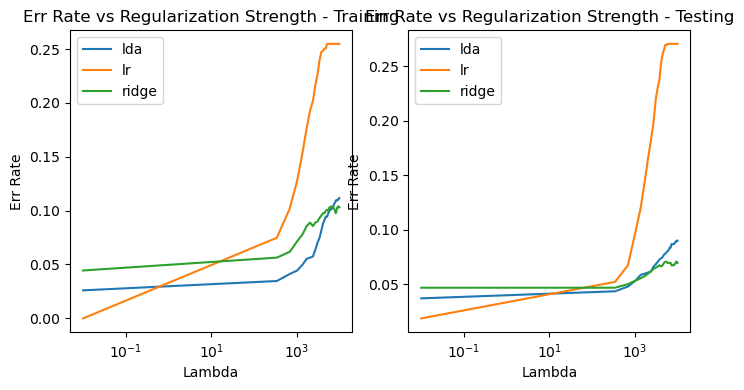

<Figure size 800x400 with 0 Axes>

In [12]:
lam_range = np.linspace(0.01, 10000, 30)

fig,axs = plt.subplots(1,2)
plt.figure()
axs[0].set_title('Err Rate vs Regularization Strength - Training') 
axs[0].set_xlabel('Lambda') 
axs[0].set_ylabel('Err Rate') 
axs[1].set_title('Err Rate vs Regularization Strength - Testing') 
axs[1].set_xlabel('Lambda')
axs[1].set_ylabel('Err Rate') 
axs[0].semilogx(lam_range, err_rate_lda_train, label='lda')
axs[1].semilogx(lam_range, err_rate_lda_test, label='lda')
axs[0].semilogx(lam_range, err_rate_lr_train, label='lr')
axs[1].semilogx(lam_range, err_rate_lr_test, label='lr')
axs[0].semilogx(lam_range, err_rate_ridge_train, label='ridge')
axs[1].semilogx(lam_range, err_rate_ridge_test, label='ridge')
axs[0].legend(loc='best')
axs[1].legend(loc='best')